In [1]:
from oauth2client.service_account import ServiceAccountCredentials
import gspread, pprint
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('bplinebot-3ccea59ad6d6.json', scope)
client = gspread.authorize(creds)
pp = pprint.PrettyPrinter()
def get_client():
    scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name('bplinebot-3ccea59ad6d6.json', scope)
    client = gspread.authorize(creds)
    return client

In [3]:
#sheet = client.open('AbbokIncomeAssesmentV03').get_worksheet(2)
spread = client.open('userCheckin')

In [4]:
spread.worksheets()

[<Worksheet 'sum' id:576946557>,
 <Worksheet 'log' id:0>,
 <Worksheet 'type' id:252782580>,
 <Worksheet 'userStatus' id:1060831238>,
 <Worksheet 'key' id:1108603979>]

In [5]:
sheet = spread.worksheet('log')

In [6]:
list_of_lists = sheet.get_all_values()

In [50]:
df = pd.DataFrame(list_of_lists[1:], columns = list_of_lists[0])
df = df[pd.to_datetime(df['DATE']).dt.month == 8]#datetime.today().month
df.head(10)

,ID,DATE,TIME,USER_ID,TYPE
264,265,2019/08/01,09:52 AM,7,1
265,266,2019/08/01,12:07 PM,4,1
266,267,2019/08/01,06:45 PM,4,0
267,268,2019/08/01,06:50 PM,7,0
268,269,2019/08/02,10:01 AM,7,1
269,270,2019/08/02,11:06 AM,2,1
270,271,2019/08/02,04:17 PM,2,0
271,272,2019/08/02,07:01 PM,7,0
272,273,2019/08/05,09:55 AM,3,1
273,274,2019/08/05,10:08 AM,7,1


In [51]:
df['TIME'] = pd.to_datetime(df['TIME']).values.astype(np.int64)
df['DATE'] = pd.to_datetime(df['DATE']).dt.date
df['USER_ID'] = df['USER_ID'].astype(int)
df['TYPE'] = df['TYPE'].astype(int)
df = df.set_index('ID')
df.shape

(90, 4)

In [52]:
df2 = pd.DataFrame(df.groupby(['USER_ID', 'TYPE'])['TIME'].mean())

In [53]:
df2['INOUT'] = pd.to_datetime(df2['TIME']).dt.time
df2

TIME            INOUT
USER_ID TYPE                                      
1       0     1565985528000000000         19:58:48
        1     1565961710000000000         13:21:50
2       0     1565977608000000000         17:46:48
        1     1565953014000000000         10:56:54
3       0     1565986440000000000         20:14:00
        1     1565951902500000000  10:38:22.500000
4       0     1565982600000000000         19:10:00
        1     1565960317500000000  12:58:37.500000
7       0     1565982462000000000         19:07:42
        1     1565948798181818112  09:46:38.181818
8       0     1565980560000000000         18:36:00
        1     1565948475000000000         09:41:15

In [54]:
df2 = df2.reset_index()

In [55]:
w_out = df2[df2['TYPE'] == 0].reset_index().drop(["index","TYPE"], axis=1)
w_in = df2[df2['TYPE'] == 1].reset_index().drop(["index","TYPE"], axis=1)

In [56]:
w_total = w_out.copy()
w_total['TIME'] = w_out['TIME'] - w_in['TIME']
w_total

,USER_ID,TIME,INOUT
0,1,23818000000000,19:58:48
1,2,24594000000000,17:46:48
2,3,34537500000000,20:14:00
3,4,22282500000000,19:10:00
4,7,33663818181888,19:07:42
5,8,32085000000000,18:36:00


In [57]:
w_total['TIME'] = pd.to_datetime(w_total['TIME']).dt.time

In [58]:
w_total

,USER_ID,TIME,INOUT
0,1,06:36:58,19:58:48
1,2,06:49:54,17:46:48
2,3,09:35:37.500000,20:14:00
3,4,06:11:22.500000,19:10:00
4,7,09:21:03.818181,19:07:42
5,8,08:54:45,18:36:00


In [59]:
w_total[w_total['USER_ID'] == 1]['TIME'].values[0].strftime("%H:%M:%S")

'06:36:58'

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

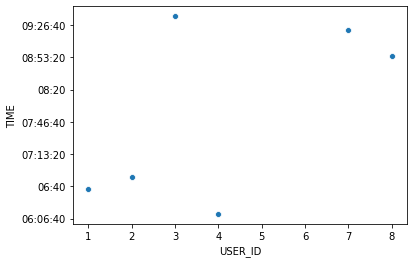

In [61]:
base_color = sb.color_palette()[0]
sb.scatterplot(data = w_total, y = 'TIME', x='USER_ID', color = base_color);

In [17]:
def get_user_key(approve=True, check_is_in=False, isw='out'):
    client = get_client()
    sheet = client.open('userCheckin').worksheet('userStatus')
    user_id = sheet.col_values(2)[1:]
    is_approve = sheet.col_values(6)[1:]
    is_in = sheet.col_values(4)[1:]
    is_in = [int(i) for i in is_in]
    is_approve = [1 if i == 'APPROVE' else 0 for i in is_approve]
    approve_mem = [id for id, i in zip(user_id, is_approve) if i == 1]

    if approve is False:
        print('1')
        return user_id
    else:
        if check_is_in:
            if isw == 'out':
                out_mem = [id for id, i in zip(user_id, is_in) if i == 0]
                print('2')
                return out_mem
            if isw == 'in':
                in_mem = [id for id, i in zip(user_id, is_in) if i == 1]
                print('3')
                return in_mem
            print('4')
        return approve_mem

In [21]:
get_user_key(check_is_in=True, isw='in')

3


['U7612d77bbca83f04d6acf5e27333edeb',
 'U262184d96cc22dfb837493e3ff6ca85a',
 'Ub4cd6bb2dc9548dd416a35e5b7488c09',
 'Ube7c6d3358f6994218ffb623d4d8a06e',
 'U5ac4ec185e02185b6eae0d54d56f7d10']

In [19]:
for i in get_user_key():
    print(i)

U7612d77bbca83f04d6acf5e27333edeb
U262184d96cc22dfb837493e3ff6ca85a
U03fe1d43c072db5c3dde2f2a20fddcb9
Ub4cd6bb2dc9548dd416a35e5b7488c09
Ube7c6d3358f6994218ffb623d4d8a06e
U5ac4ec185e02185b6eae0d54d56f7d10


In [17]:
'!ct sfasfasfad'.startswith('!ct ')

True

In [19]:
client = get_client()
sheet = client.open('userCheckin').worksheet('userStatus')
user_id = sheet.col_values(2)[1:]
user_name = sheet.col_values(3)[1:]
is_in = sheet.col_values(4)[1:]
is_inR = [u for i, u in zip(is_in, user_id) if i == '1']
user_in = [y for i, y in zip(is_in, user_name) if i == '1']


In [21]:
user_in

['TAAN', 'SNOOK', 'TOEY', 'NUT', 'JOEY']

In [18]:
for i, v in zip(is_in, user_name):
    print(i, v)

U262184d96cc22dfb837493e3ff6ca85a BEST
U03fe1d43c072db5c3dde2f2a20fddcb9 TAAN
Ube7c6d3358f6994218ffb623d4d8a06e SNOOK
U5ac4ec185e02185b6eae0d54d56f7d10 TEAM
U99cc103c604322964f2d16dd8cb52d8c BAM
